<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Tabular_Playground_Series_May_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/tabular-playground-series-may-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/tabular-playground-series-may-2021_test.csv')
train.shape, test.shape

((100000, 52), (50000, 51))

In [5]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2


In [8]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

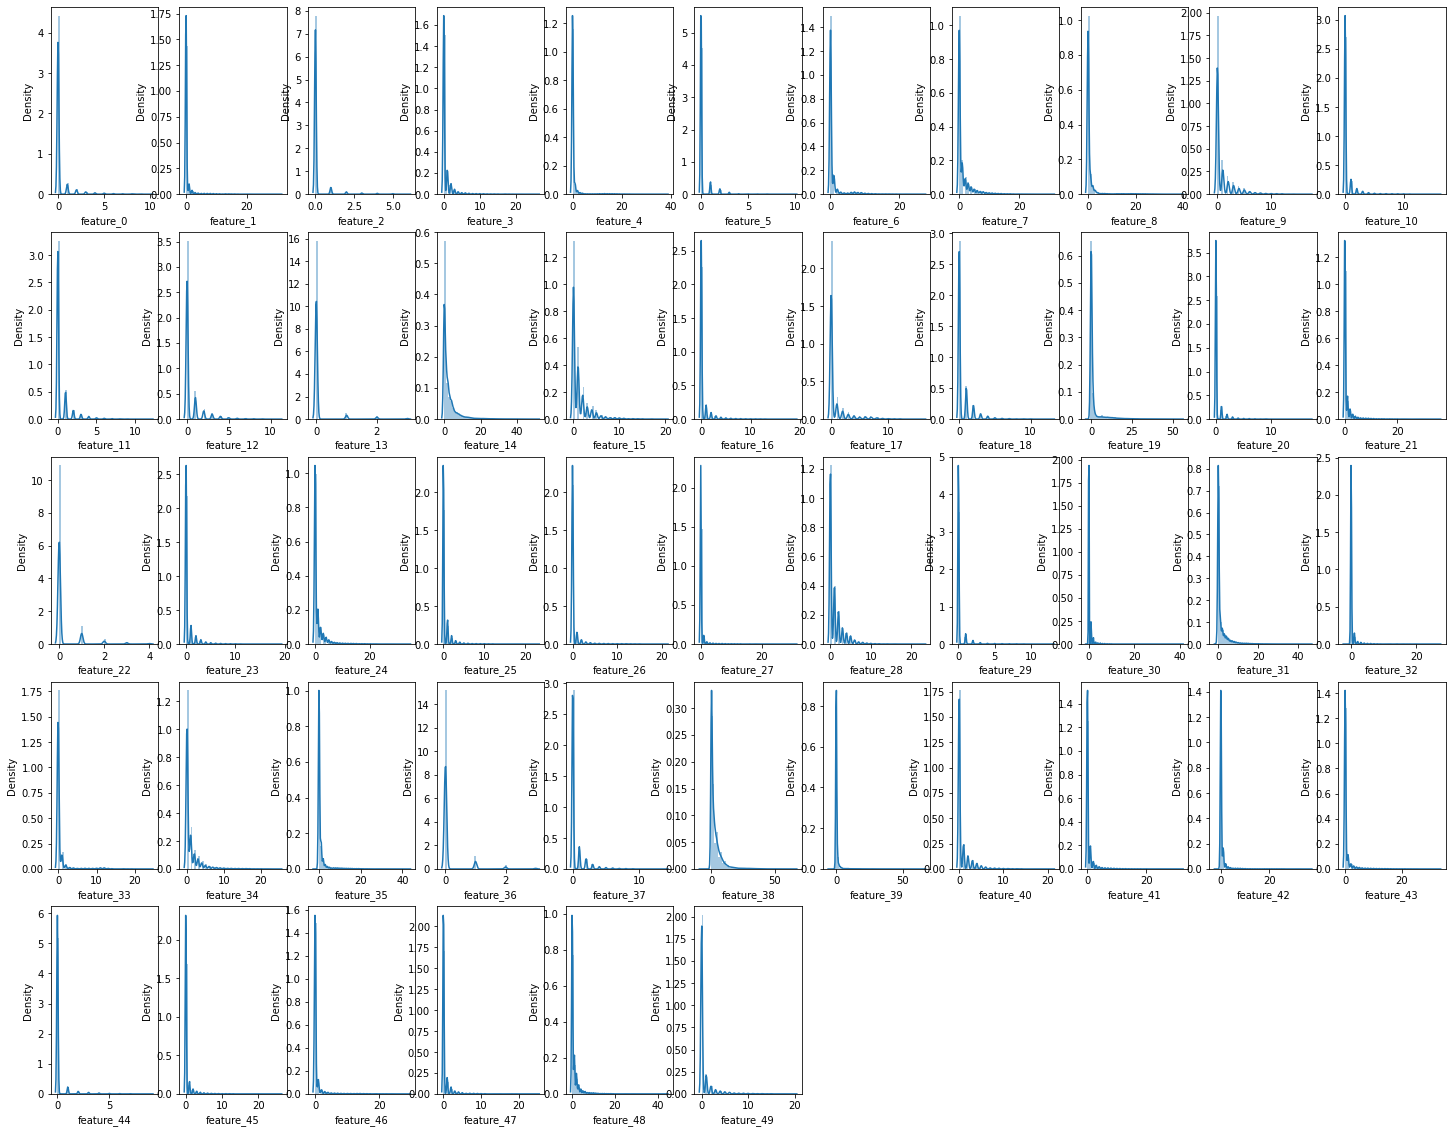

In [17]:
fig = plt.figure(figsize=(25,20))
for i, j in enumerate(train.drop(columns=['id', 'target']).columns):
  plt.subplot(5,11, i+1)
  sns.distplot(train[j])
plt.subplots_adjust()

In [63]:
def scaling(df):
  for i in df.columns:
    if i in ['id', 'target']:
      continue
    if df[i].skew() > 0.5:
      df[i] = np.log1p(1+df[i])
  return df

In [55]:
def normaliation(df):
  for i in df.columns:
    if i in ['id', 'target']:
      continue
    df[i] = df[i].astype('float')
    df[i] = stats.yeojohnson(df[i], stats.yeojohnson_normmax(df[i]+1))

  return df

In [176]:
def aggregation(df):
  temp_col = []
  temp_agg = df.groupby('id').agg(['median'])
  for i in temp_agg.columns.levels[0]:
    for j in temp_agg.columns.levels[1]:
      temp_col.append(f'{i}-{j}')

  temp_agg.columns = temp_col

  corr_matrix = temp_agg.corr()
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
  to_drop = [c for c in upper.columns if any(abs(upper[c]) > 0.9)]

  temp_agg.drop(columns=to_drop)

  return temp_agg
# 성능 안좋음

In [177]:
train_agg = aggregation(train)
test_agg = aggregation(test)

In [179]:
train = train.merge(train_agg, how='left', on='id')
test = test.merge(test_agg, how='left', on='id')

In [ ]:
# 클러스터링까지

# 로그변환과 normalization을 하면 데이터가 이상해진다...

In [3]:
pip install catboost

In [4]:
pip install optuna

In [5]:
from sklearn.preprocessing import LabelEncoder, robust_scale
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import log_loss
import optuna
import catboost
import xgboost
import lightgbm as lgbm

In [6]:
x_train = train.drop(columns=['id', 'target'])
y_train = train['target']
x_test = test.drop(columns=['id'])
x_train.shape, y_train.shape, x_test.shape

((100000, 50), (100000,), (50000, 50))

In [7]:
y_train = pd.Series(LabelEncoder().fit_transform(y_train))

In [8]:
train_col = x_train.columns
test_col = x_test.columns

x_train = pd.DataFrame(robust_scale(x_train), columns=train_col)
x_test = pd.DataFrame(robust_scale(x_test), columns=test_col)

# Clustering

In [ ]:
from sklearn.clustering import KMeans

# PCA

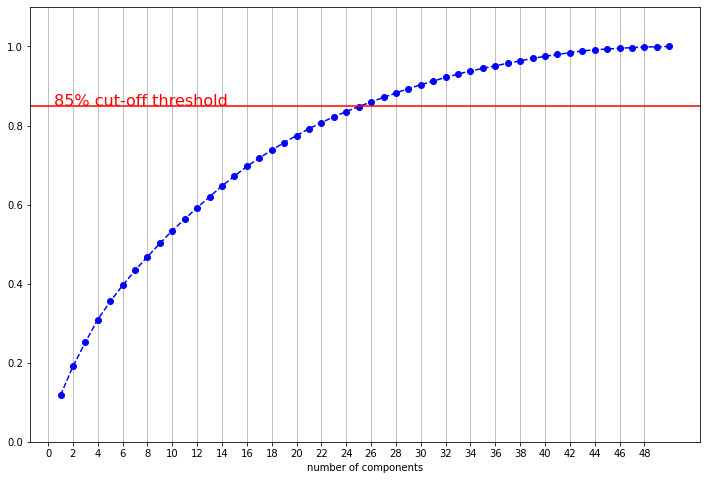

In [156]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(svd_solver='auto', whiten=True)
pca.fit(x_train)

fig, ax = plt.subplots(figsize=(12,8))
xi = np.arange(1, len(x_train.columns)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('number of components')
plt.xticks(np.arange(0, len(x_train.columns), step=2))

plt.axhline(y=0.85, color='r', linestyle='-')
plt.text(0.5, 0.85, '85% cut-off threshold', color='red', fontsize=16)

ax.grid(axis='x')
plt.show()
# 성능이 별로 안좋다...

In [157]:
pca = PCA(n_components=25,svd_solver='auto', whiten=True)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

# 여기까지 PCA 안좋다...

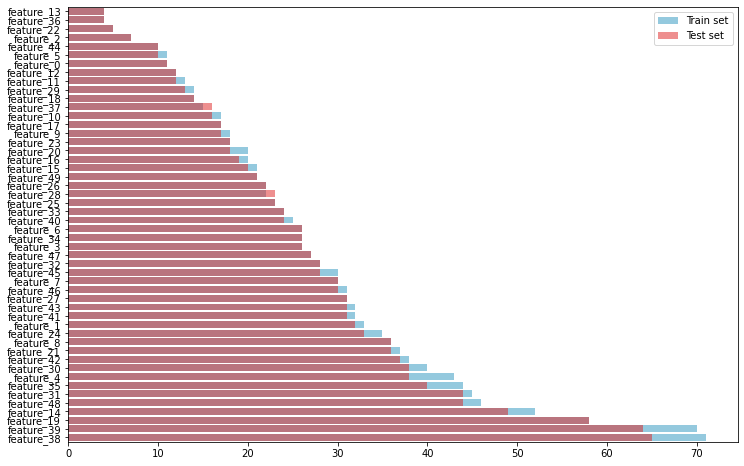

In [109]:
a = x_train.nunique().sort_values()
b = x_test.nunique().sort_values()
plt.figure(figsize=(12, 8))
sns.barplot(y=a.index, x=a, color='skyblue', label='Train set')
sns.barplot(y=b.index, x=b, color='red', label='Test set', alpha=0.5)
plt.legend()

In [140]:
pip install eli5

     |████████████████████████████████| 112kB 8.2MB/s 


In [183]:
# feature selection
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostClassifier(loss_function='MultiClass',
                                   eval_metric='MultiClass',
                                   verbose=False,
                                   task_type='GPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [184]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_sel, scoring='neg_log_loss', random_state=12)
perm.fit(X_test, Y_test)

PermutationImportance(cv='prefit',
                      estimator=<catboost.core.CatBoostClassifier object at 0x7fcef4eaded0>,
                      n_iter=5, random_state=12, refit=True,
                      scoring='neg_log_loss')

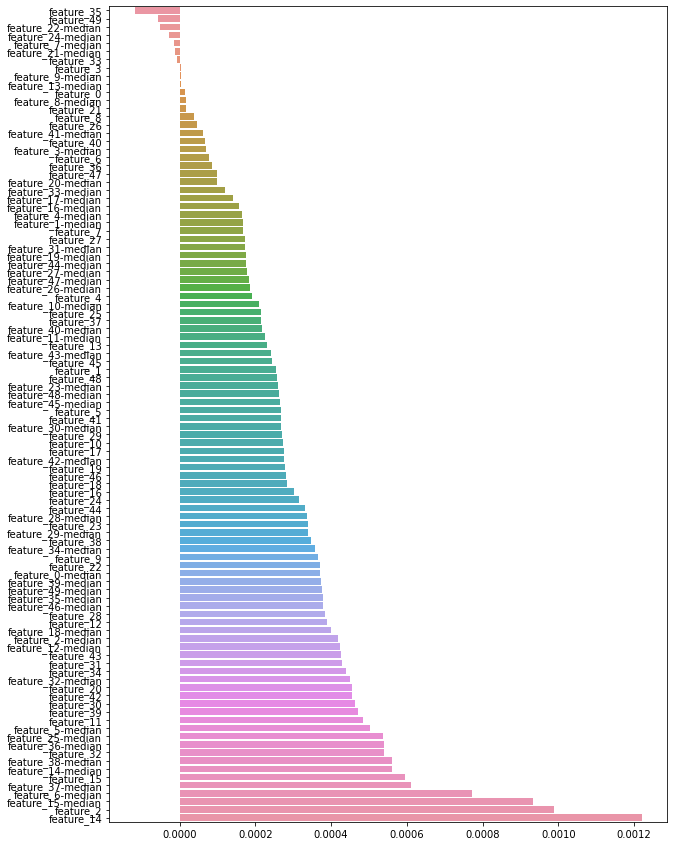

In [187]:
importance = pd.Series(perm.feature_importances_, index=train.drop(columns=['id', 'target']).columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

In [188]:
x_train = x_train.drop(columns=drop_sel)
x_test = x_test.drop(columns=drop_sel)

In [189]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'MultiClass',
              'task_type':"GPU",
              'eval_metric':'MultiClass',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide'
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [190]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(f'Best trial score{study.best_trial.value}, params{study.best_trial.params}')

[I 2021-06-30 09:29:45,642] A new study created in memory with name: no-name-ac5b011b-d557-4300-8242-8c8f04df0c7c
[I 2021-06-30 09:29:58,420] Trial 0 finished with value: 1.0856829614899948 and parameters: {'iterations': 5420, 'learning_rate': 0.2651898908894167, 'reg_lambda': 89.99064098456242, 'subsample': 0.17707321619757577, 'random_strength': 37.84598958930573, 'depth': 1, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 9}. Best is trial 0 with value: 1.0856829614899948.
[I 2021-06-30 09:30:00,970] Trial 1 finished with value: 1.0907547539020852 and parameters: {'iterations': 22901, 'learning_rate': 0.37728400010498264, 'reg_lambda': 68.46945314388518, 'subsample': 0.9367120302100725, 'random_strength': 30.81551223096809, 'depth': 12, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 3}. Best is trial 0 with value: 1.0856829614899948.
[I 2021-06-30 09:30:04,303] Trial 2 finished with value: 1.0880117380142074 and parameters: {'iterations': 20173, 'learning_rate': 0.18481

Best trial score1.085130784915258, params{'iterations': 13719, 'learning_rate': 0.4127963264093921, 'reg_lambda': 45.19198536547615, 'subsample': 0.7674201150740568, 'random_strength': 22.668800746495, 'depth': 1, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 1}


In [191]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds_cat = np.zeros((x_test.shape[0], y_train.nunique()))
params_cat = {
    'iterations':study.best_params['iterations'],
    'loss_function':'MultiClass',
    'task_type':"GPU",
    'eval_metric':'MultiClass',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth': study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Lossguide'
}

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat += model_cat.predict_proba(x_test) / skf.n_splits

0:	learn: 1.1941079	test: 1.1941857	best: 1.1941857 (0)	total: 3.59ms	remaining: 49.2s
100:	learn: 1.0946541	test: 1.0984601	best: 1.0984601 (100)	total: 264ms	remaining: 35.5s
200:	learn: 1.0900705	test: 1.0955252	best: 1.0955231 (199)	total: 537ms	remaining: 36.1s
300:	learn: 1.0878599	test: 1.0944692	best: 1.0944692 (300)	total: 805ms	remaining: 35.9s
400:	learn: 1.0864255	test: 1.0938831	best: 1.0938831 (400)	total: 1.09s	remaining: 36.4s
500:	learn: 1.0853734	test: 1.0937267	best: 1.0936815 (455)	total: 1.39s	remaining: 36.7s
600:	learn: 1.0845706	test: 1.0935873	best: 1.0935331 (543)	total: 1.67s	remaining: 36.4s
700:	learn: 1.0839047	test: 1.0935235	best: 1.0934571 (677)	total: 1.94s	remaining: 36s
bestTest = 1.093457129
bestIteration = 677
Shrink model to first 678 iterations.
0:	learn: 1.1940501	test: 1.1942962	best: 1.1942962 (0)	total: 3.6ms	remaining: 49.4s
100:	learn: 1.0951262	test: 1.0970677	best: 1.0970677 (100)	total: 247ms	remaining: 33.2s
200:	learn: 1.0906389	test: 

In [13]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'n_estimators':trial.suggest_int("n_estimators", 2000, 25000),
              'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 30.0),
              'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 30.0),
              'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
              'subsample': trial.suggest_uniform('subsample', 0,1),
              'learning_rate': trial.suggest_uniform('learning_rate', 0, 0.1 ),
              'max_depth': trial.suggest_int('max_depth', 1,12),
              'num_leaves' : trial.suggest_int('num_leaves', 2, 100),
              'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
              'min_child_weight' : trial.suggest_loguniform('min_child_weight' , 1e-5 , 1),
              'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
              'cat_l2': trial.suggest_int('cat_l2',1,20),
              'metric': 'multi_logloss', 
              'random_state' : trial.suggest_categorical('random_state',[13]),
              'objective': 'multiclass',
              'tree_method':'gpu_hist'
               }
    model = xgboost.XGBClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)


    log_loss_multi = log_loss(y_test, y_preds)
    
    return log_loss_multi

In [14]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(f'Best trial score{study.best_trial.value}, params{study.best_trial.params}')

[I 2021-06-30 11:49:14,192] A new study created in memory with name: no-name-fac46561-c5ca-4d36-a56f-b67c7e1a191e
[I 2021-06-30 11:49:16,454] Trial 0 finished with value: 1.377924437135458 and parameters: {'n_estimators': 8709, 'reg_alpha': 12.24751824344364, 'reg_lambda': 6.670410731043516, 'colsample_bytree': 0.6, 'subsample': 0.6021533759307922, 'learning_rate': 0.02080897845217361, 'max_depth': 2, 'num_leaves': 62, 'min_child_samples': 67, 'min_child_weight': 0.9504555733559261, 'cat_smooth': 98, 'cat_l2': 20, 'random_state': 13}. Best is trial 0 with value: 1.377924437135458.
[I 2021-06-30 11:49:33,330] Trial 1 finished with value: 1.0953160401560367 and parameters: {'n_estimators': 16695, 'reg_alpha': 0.001235055739060126, 'reg_lambda': 0.000613866633729072, 'colsample_bytree': 0.6, 'subsample': 0.5758937059038759, 'learning_rate': 0.06596527107591744, 'max_depth': 9, 'num_leaves': 85, 'min_child_samples': 76, 'min_child_weight': 0.00922594730338476, 'cat_smooth': 35, 'cat_l2': 7

Best trial score1.08627678719908, params{'n_estimators': 20610, 'reg_alpha': 4.477536841233771, 'reg_lambda': 26.193216307436078, 'colsample_bytree': 0.8, 'subsample': 0.6540874182230872, 'learning_rate': 0.05688145635598608, 'max_depth': 3, 'num_leaves': 42, 'min_child_samples': 56, 'min_child_weight': 0.0023167705877421762, 'cat_smooth': 73, 'cat_l2': 16, 'random_state': 13}


In [40]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds_xgb = np.zeros((x_test.shape[0], y_train.nunique()))
params_xgb = {
    'n_estimators':study.best_params['n_estimators'],
    'reg_alpha': study.best_params['reg_alpha'],
    'reg_lambda': study.best_params['reg_lambda'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'subsample': study.best_params['subsample'],
    'learning_rate': study.best_params['learning_rate'],
    'max_depth': study.best_params['max_depth'],
    'num_leaves' : study.best_params['num_leaves'],
    'min_child_samples': study.best_params['min_child_samples'],
    'min_child_weight' : study.best_params['min_child_weight'],
    'cat_smooth' : study.best_params['cat_smooth'],
    'cat_l2': study.best_params['cat_l2'],
    'random_state' : study.best_params['random_state'],
    'objective': 'multiclass',
    'tree_method':'gpu_hist',
    'grow_policy' : 'lossguide',
}

for i, (train_index, valid_index) in enumerate(skf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBClassifier(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], early_stopping_rounds=70, verbose=100, eval_metric='mlogloss')

  preds_xgb += model_xgb.predict_proba(x_test) / skf.n_splits

[0]	validation_0-mlogloss:1.36391
Will train until validation_0-mlogloss hasn't improved in 70 rounds.
[100]	validation_0-mlogloss:1.10419
[200]	validation_0-mlogloss:1.0989
[300]	validation_0-mlogloss:1.09651
[400]	validation_0-mlogloss:1.09531
[500]	validation_0-mlogloss:1.09478
[600]	validation_0-mlogloss:1.09443
[700]	validation_0-mlogloss:1.09436
Stopping. Best iteration:
[690]	validation_0-mlogloss:1.0943

[0]	validation_0-mlogloss:1.36366
Will train until validation_0-mlogloss hasn't improved in 70 rounds.
[100]	validation_0-mlogloss:1.10317
[200]	validation_0-mlogloss:1.09756
[300]	validation_0-mlogloss:1.09483
[400]	validation_0-mlogloss:1.09339
[500]	validation_0-mlogloss:1.09249
[600]	validation_0-mlogloss:1.09204
[700]	validation_0-mlogloss:1.09177
[800]	validation_0-mlogloss:1.0916
[900]	validation_0-mlogloss:1.09164
Stopping. Best iteration:
[864]	validation_0-mlogloss:1.09156

[0]	validation_0-mlogloss:1.36394
Will train until validation_0-mlogloss hasn't improved in 70 

In [42]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/tabular-playground-series-may-2021_sample_submission.csv')
submit = submit.set_index('id')

In [43]:
for i in range(y_train.nunique()):
  submit.iloc[:, i] = preds_xgb[:, i]

In [44]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-may/submit4.csv')